# Setup

In [14]:
%matplotlib notebook
LOG_PLOT = False
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import os
from helper import *

## ECDC Data

In [15]:


def plot_selection(selection, roll_days=7, log=False):
    

    f,ax = plt.subplots()
    ax.plot(selection.dateRep, selection['cases'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
#     ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(selection.dateRep, selection['cases'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    if log:
        plt.yscale('log')
        
    plt.title(selection.iloc[0].countriesAndTerritories.replace('_', ' '))
    plt.tight_layout()

    return f


def select_country(geoId):
    selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True)
    return selection

def plot_country(geoId, **kwargs):
    return plot_selection(select_country(geoId), **kwargs)
    
df = ecdc()


## Austria - from Gesundheitsminesterium

In [16]:

def plot_Austria(roll_days=7, log=False):
    df = fetch_Austria()
    f,ax = plt.subplots()
    ax.plot(df.time, df['tägliche Erkrankungen'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(df.time, df['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    plt.title('Positive COVID tests')
    if log:
        plt.yscale('log')
    plt.tight_layout()
    return f

df_at  = at()


## DF Subsets

In [17]:
SELECTION =  df[df.geoId.isin(['AT', 'IN', 'US', 'UK', 'DE', 'IT', 'NL'])]
EU = df[df.continentExp=='Europe']
AMERICA = df[(df.continentExp=='America')]


# Overview

## Selected Countries

In [18]:
overview(SELECTION)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
India                     6394068          575498       82214  81484  97894   
United_States_of_America  7277814          299397       42771  44771  78427   
United_Kingdom             460178           43815        6259   6914   7143   
Netherlands                123966           20932        2990   3253   3293   
Germany                    294395           14172        2025   2673   6294   
Italy                      317409           13086        1869   2548   6557   
Austria                     46317            5071         724    564   1146   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
India                      99773            7483        1069   1095  2003   
United_States_of_America  207808            4998         714    880  4928   
United_Kingdom             42202             300          43     59  1224   
Netherlands                 6410             107          15     13   234   
Germany                     9508              65           9      8   315   
Italy                      35918             137          20     24   971   
Austria                      802              19           3      3    31   

                            dateRep             
                                min        max  
countriesAndTerritories                         
India                    2019-12-31 2020-10-02  
United_States_of_America 2019-12-31 2020-10-02  
United_Kingdom           2019-12-31 2020-10-02  
Netherlands              2019-12-31 2020-10-02  
Germany                  2019-12-31 2020-10-02  
Italy                    2019-12-31 2020-10-02  
Austria                  2019-12-31 2020-10-02

## Most cases in the last 7 days

### Europe

In [19]:
overview(EU).head(10)

cases                                            \
                             sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                      
France                    577505           80268       11467  13970  16096   
Spain                     778607           74398       10628   9419  31785   
Russia                   1185231           56395        8056   8945  11656   
United_Kingdom            460178           43815        6259   6914   7143   
Netherlands               123966           20932        2990   3253   3293   
Ukraine                   208959           20853        2979      0   5863   
Czechia                    74255           15881        2269   5336   5336   
Germany                   294395           14172        2025   2673   6294   
Italy                     317409           13086        1869   2548   6557   
Romania                   129658           11604        1658   2086   2158   

                        deaths                                           \
                           sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                   
France                   32019             508          73     63  2004   
Spain                    31973             855         122    182  1179   
Russia                   20891             943         135    169   312   
United_Kingdom           42202             300          43     59  1224   
Netherlands               6410             107          15     13   234   
Ukraine                   4193             436          62     64   129   
Czechia                    678             111          16     23    24   
Germany                   9508              65           9      8   315   
Italy                    35918             137          20     24   971   
Romania                   4862             271          39     37    60   

                           dateRep             
                               min        max  
countriesAndTerritories                        
France                  2019-12-31 2020-10-02  
Spain                   2019-12-31 2020-10-01  
Russia                  2019-12-31 2020-10-02  
United_Kingdom          2019-12-31 2020-10-02  
Netherlands             2019-12-31 2020-10-02  
Ukraine                 2020-03-04 2020-10-02  
Czechia                 2019-12-31 2020-10-02  
Germany                 2019-12-31 2020-10-02  
Italy                   2019-12-31 2020-10-02  
Romania                 2019-12-31 2020-10-02

### America

In [7]:
overview(AMERICA).head(5)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
United_States_of_America  7233043          298839       42691  41982  78427   
Brazil                    4810935          186050       26579  33413  69074   
Argentina                  750988           86189       12313  14392  17213   
Colombia                   829679           45411        6487   5637  13056   
Mexico                     743216           33167        4738   5053   9556   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
United_States_of_America  206928            5019         717    930  4928   
Brazil                    143952            4975         711   1031  1595   
Argentina                  16937            2561         366    418   573   
Colombia                   25998            1252         179    170   400   
Mexico                     77646            2697         385    483  1091   

                            dateRep             
                                min        max  
countriesAndTerritories                         
United_States_of_America 2019-12-31 2020-10-01  
Brazil                   2019-12-31 2020-10-01  
Argentina                2020-03-04 2020-10-01  
Colombia                 2020-03-07 2020-10-01  
Mexico                   2019-12-31 2020-10-01

### World

In [8]:
overview(df).head(10)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
India                     6312584          580066       82867  86821  97894   
United_States_of_America  7233043          298839       42691  41982  78427   
Brazil                    4810935          186050       26579  33413  69074   
Argentina                  750988           86189       12313  14392  17213   
France                     563535           82394       11771  12845  16096   
Spain                      769188           75632       10805  11016  31785   
Russia                    1176286           54045        7721   8481  11656   
Colombia                   829679           45411        6487   5637  13056   
United_Kingdom             453264           43535        6219   7108   7143   
Israel                     248133           43443        6206  11207  11827   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
India                      98678            7529        1076   1181  2003   
United_States_of_America  206928            5019         717    930  4928   
Brazil                    143952            4975         711   1031  1595   
Argentina                  16937            2561         366    418   573   
France                     31956             497          71     63  2004   
Spain                      31791             757         108    177  1179   
Russia                     20722             923         132    177   312   
Colombia                   25998            1252         179    170   400   
United_Kingdom             42143             281          40     71  1224   
Israel                      1571             246          35     43    71   

                            dateRep             
                                min        max  
countriesAndTerritories                         
India                    2019-12-31 2020-10-01  
United_States_of_America 2019-12-31 2020-10-01  
Brazil                   2019-12-31 2020-10-01  
Argentina                2020-03-04 2020-10-01  
France                   2019-12-31 2020-10-01  
Spain                    2019-12-31 2020-09-30  
Russia                   2019-12-31 2020-10-01  
Colombia                 2020-03-07 2020-10-01  
United_Kingdom           2019-12-31 2020-10-01  
Israel                   2019-12-31 2020-10-01

## Lowset number of new cases in the last 7 days

### Europe*

\*among countries with population of at least 1 million

In [9]:
overview(EU[EU.popData2019>1*10**6]).tail(5)

cases                                         deaths  \
                           sum last_7_days_sum rolling_avg latest  max    sum   
countriesAndTerritories                                                         
Finland                   9992             704         101    100  267    344   
Serbia                   33551             471          67     72  467    749   
Kosovo                   15620             350          50     46  496    625   
Estonia                   3371             338          48     56  134     64   
Latvia                    1824             252          36     95   95     37   

                                                                  dateRep  \
                        last_7_days_sum rolling_avg latest max        min   
countriesAndTerritories                                                     
Finland                               1           0      1  43 2019-12-31   
Serbia                                5           1      0  18 2020-03-07   
Kosovo                                9           1      0  40 2020-03-14   
Estonia                               0           0      0   6 2019-12-31   
Latvia                                1           0      0   4 2020-03-03   

                                    
                               max  
countriesAndTerritories             
Finland                 2020-10-01  
Serbia                  2020-10-01  
Kosovo                  2020-10-01  
Estonia                 2020-10-01  
Latvia                  2020-10-01

### America*

\*among countries with population of at least 10 million

In [10]:
overview(AMERICA[AMERICA.popData2019>1*10**7]).tail(5)


cases                                           \
                            sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                    
Guatemala                 91746            4304         615    778  4233   
Bolivia                  135311            3321         474    670  2687   
Dominican_Republic       112209            2472         353    309  2147   
Cuba                       5597             327          47     66    93   
Haiti                      8766             120          17     19   284   

                        deaths                                           \
                           sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                   
Guatemala                 3246              92          13      8    74   
Bolivia                   7965             234          33     34  1610   
Dominican_Republic        2105              31           4      4    39   
Cuba                       122               4           1      0     6   
Haiti                      229               4           1      0    12   

                           dateRep             
                               min        max  
countriesAndTerritories                        
Guatemala               2020-03-15 2020-10-01  
Bolivia                 2020-03-12 2020-10-01  
Dominican_Republic      2019-12-31 2020-10-01  
Cuba                    2020-03-12 2020-10-01  
Haiti                   2020-03-20 2020-10-01

### World*
\*among countries with population of at least 10 million

In [11]:
overview( df[df.popData2019>1*10**7]).tail(5)


cases                                          \
                              sum last_7_days_sum rolling_avg latest  max   
countriesAndTerritories                                                     
Taiwan                        514               5           1      0   31   
Niger                        1197               4           1      1   69   
Yemen                        2035               3           0      0  116   
Cambodia                      277               2           0      0   35   
United_Republic_of_Tanzania   509               0           0      0  174   

                            deaths                                         \
                               sum last_7_days_sum rolling_avg latest max   
countriesAndTerritories                                                     
Taiwan                           7               0           0      0   3   
Niger                           69               0           0      0   5   
Yemen                          588               1           0      0  52   
Cambodia                         0               0           0      0   0   
United_Republic_of_Tanzania     21               0           0      0   6   

                               dateRep             
                                   min        max  
countriesAndTerritories                            
Taiwan                      2019-12-31 2020-10-01  
Niger                       2020-03-21 2020-10-01  
Yemen                       2020-04-10 2020-10-01  
Cambodia                    2019-12-31 2020-10-01  
United_Republic_of_Tanzania 2020-03-17 2020-10-01

# Austria
Compare ECDC data with Gesundheitsminesterium Data

## Plots

In [12]:
plot_Austria();
plot_country('AT', log=LOG_PLOT)

NameError: name 'fetch_Austria' is not defined

## Last 7 days

In [13]:
overview(df[df.geoId=='AT'])

cases                                           \
                           sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                   
Austria                  45753            5195         742   1146  1146   

                        deaths                                         \
                           sum last_7_days_sum rolling_avg latest max   
countriesAndTerritories                                                 
Austria                    799              22           3      3  31   

                           dateRep             
                               min        max  
countriesAndTerritories                        
Austria                 2019-12-31 2020-10-01

### Weekday bias

<IPython.core.display.Javascript object>


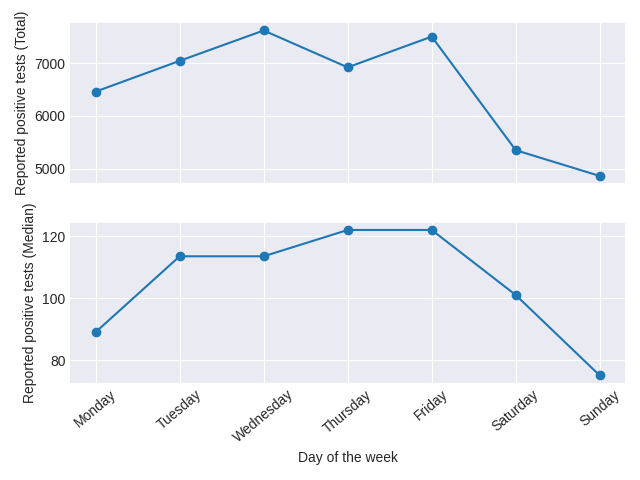

In [18]:
f, ax = plt.subplots(nrows=2, sharex=True)
df_at.groupby(['weekday']).sum()['tägliche Erkrankungen'].plot(ax=ax[0], marker='o')
ax[0].set_ylabel('Reported positive tests (Total)')
df_at.groupby(['weekday']).median()['tägliche Erkrankungen'].plot(ax=ax[1], marker='o')
ax[1].set_ylabel('Reported positive tests (Median)')
ax[1].set_xlabel('Day of the week')
ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(WEEKDAYS, rotation=40)
plt.tight_layout()

# India

<IPython.core.display.Javascript object>


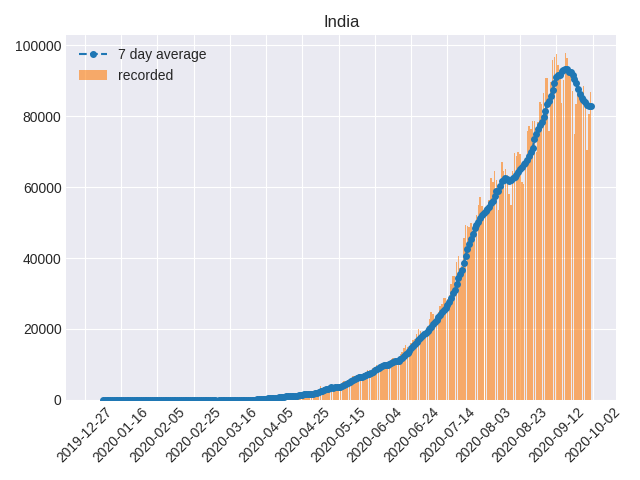

In [19]:
plot_country('IN', log=LOG_PLOT);

# USA

<IPython.core.display.Javascript object>


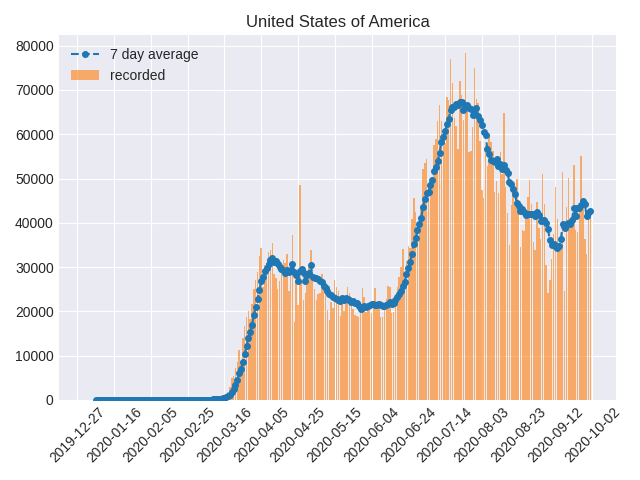

In [20]:
plot_country('US', log=LOG_PLOT);


# Germany

<IPython.core.display.Javascript object>


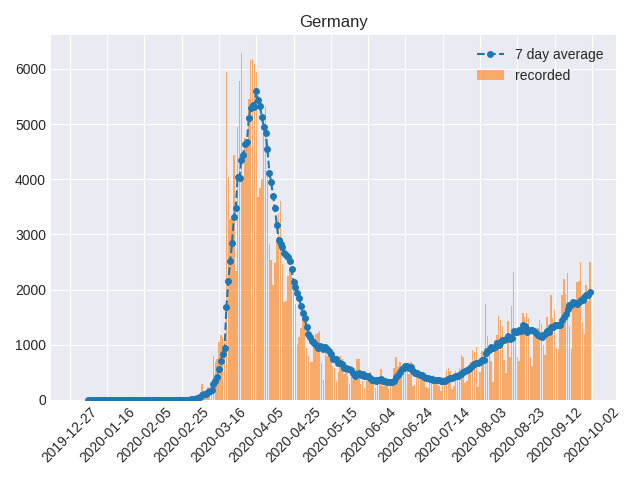

In [21]:
plot_country('DE', log=LOG_PLOT);

## UK

<IPython.core.display.Javascript object>


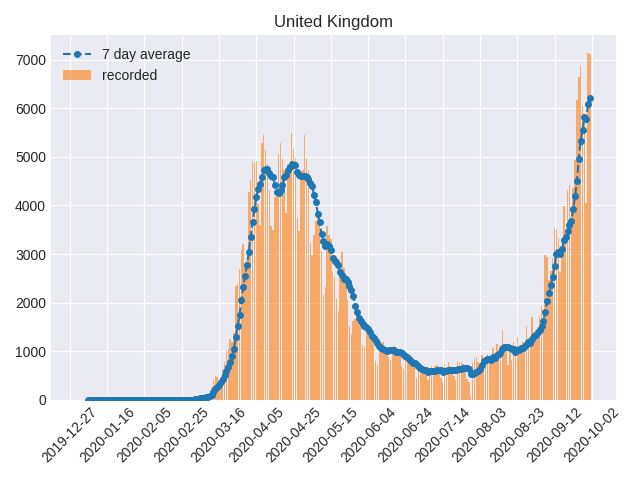

In [22]:
plot_country('UK', log=LOG_PLOT);

# China

<IPython.core.display.Javascript object>


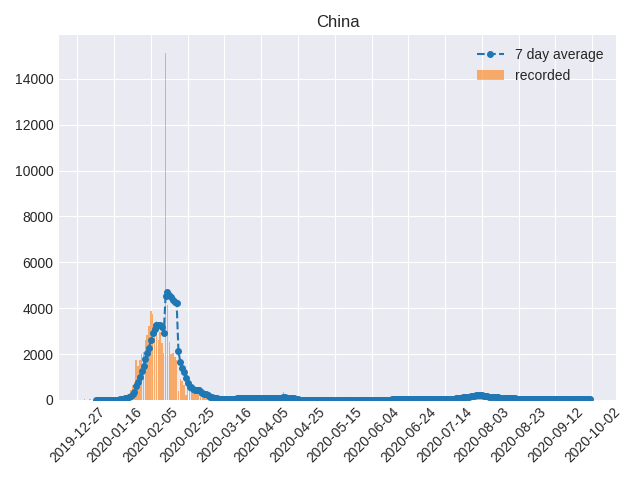

In [23]:
plot_country('CN', log=LOG_PLOT);


# Commit and Push

In [24]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


[Errno 2] No such file or directory: 'Documents/code/covid19/'
/home/gythaogg/Documents/code/covid19/notebooks
[feature/angular f65e47d] Last run on 2020-10-01 13:03
 2 files changed, 20 insertions(+), 32 deletions(-)
fatal: The current branch feature/angular has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream origin feature/angular

